In [67]:
import numpy as np
from scipy.optimize import minimize
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt



class Kalman_regression():
    """ Kalman Filter algorithm for the linear regression beta estimation. Alpha is assumed constant. 
    
    INPUT:
    X = predictor variable. ndarray, Series or DataFrame. 
    Y = response variable.
    alpha0 = constant alpha. The regression intercept.
    beta0 = initial beta. 
    var_eta = variance of process error
    var_eps = variance of measurement error
    P0 = initial covariance of beta
    """
    
    def __init__(self, X, Y, alpha0=None, beta0=None, var_eta=None, var_eps=None, P0 = 10):
        self.alpha0 = alpha0
        self.beta0 = beta0
        self.var_eta = var_eta
        self.var_eps = var_eps
        self.P0 = P0
        self.X = np.asarray(X)
        self.Y = np.asarray(Y)
        self.loglikelihood = None
        self.R2_pre_fit = None
        self.R2_post_fit = None
        
        self.betas = None
        self.Ps = None
        
        if self.alpha0==None or self.beta0==None or self.var_eps==None:
            self.alpha0, self.beta0, self.var_eps = self.get_OLS_params()
            print("alpha0, beta0 and var_eps initialized by OLS")
            
####################  enforce X and Y to be numpy arrays ######################    
#    @property
#    def X(self):
#        return self._X
#    @X.setter
#    def X(self, value):
#        if not isinstance(value, np.ndarray):
#            raise TypeError('X must be a numpy array')
#        self._X = value
#    
#    @property
#    def Y(self):
#        return self._Y
#    @Y.setter
#    def Y(self, value):
#        if not isinstance(value, np.ndarray):
#            raise TypeError('Y must be a numpy array')
#        self._Y = value
###############################################################################    
    
    def get_OLS_params(self):
        """ Returns the OLS alpha, beta and sigma^2 (variance of epsilon)
            Y = alpha + beta * X + epsilon
        """
        beta, alpha, _ ,_ ,_  = ss.linregress(self.X, self.Y)
        resid = self.Y - beta * self.X - alpha
        sig2 = resid.var(ddof=2)
        return alpha, beta, sig2
    
    def set_OLS_params(self):
        self.alpha0, self.beta0, self.var_eps = self.get_OLS_params()
        
    
    def run(self, X=None, Y=None, var_eta=None, var_eps=None):
        """ 
            Run the Kalman Filter
        """
        
        if (X is None) and (Y is None):
            X = self.X
            Y = self.Y
        
        X = np.asarray(X)
        Y = np.asarray(Y)
        
        N = len(X)
        if len(Y) != N:
            raise ValueError("Y and X must have same length") 
    
        if var_eta is not None:
            self.var_eta = var_eta
        if var_eps is not None:
            self.var_eps = var_eps
        if self.var_eta==None:
            raise ValueError("var_eta is None")
        
        betas = np.zeros_like(X)
        Ps = np.zeros_like(X)
        res_pre = np.zeros_like(X)       # pre-fit residuals
        
        Y = Y - self.alpha0              # re-define Y
        P = self.P0
        beta = self.beta0
        
        log_2pi = np.log(2 * np.pi)
        loglikelihood = 0
    
        for k in range(N):
            # Prediction
            beta_p = beta                  # predicted beta 
            P_p = P + self.var_eta              # predicted P

            # ausiliary variables
            r = Y[k] - beta_p * X[k]
            S = P_p * X[k]**2 + self.var_eps
            KG = X[k] * P_p / S            # Kalman gain
        
            # Update
            beta = beta_p + KG * r
            P = P_p * (1 - KG * X[k])

            loglikelihood += 0.5 * ( -log_2pi - np.log(S) - (r**2/S) )      
        
            betas[k] = beta
            Ps[k] = P
            res_pre[k] = r
            
        res_post = Y - X * betas   # post fit residuals 
        sqr_err = Y - np.mean(Y)                             
        R2_pre = 1 - ( res_pre @ res_pre )/(sqr_err @ sqr_err)
        R2_post = 1 - ( res_post @ res_post )/(sqr_err @ sqr_err)
        
        self.loglikelihood = loglikelihood
        self.R2_post_fit = R2_post
        self.R2_pre_fit = R2_pre
        
        self.betas = betas 
        self.Ps = Ps
        


    def calibrate_MLE(self):
        """ Returns the result of the MLE calibration for the Beta Kalman filter, using the L-BFGS-B method. 
        The calibrated parameters are var_eta and var_eps. 
        X, Y          = Series, array, or DataFrame for the regression 
        alpha_tr      = initial alpha 
        beta_tr       = initial beta 
        var_eps_ols   = initial guess for the errors
        """

        def minus_likelihood(c):
            """ Function to minimize in order to calibrate the kalman parameters: var_eta and var_eps. """
            self.var_eps = c[0]
            self.var_eta = c[1]
            self.run()
            return -1 * self.loglikelihood
        
        result = minimize(minus_likelihood, x0=[self.var_eps, self.var_eps], 
                          method='L-BFGS-B', bounds=[[1e-15,None],[1e-15,None]], tol=1e-6)
        
        if result.success == True:
            self.beta0 = self.betas[-1]
            self.P0 = self.Ps[-1]
            self.var_eps = result.x[0] 
            self.var_eta = result.x[1]
            print("Optimization converged successfully")
            print( "var_eps = {}, var_eta = {}".format(result.x[0], result.x[1]) )


    def calibrate_R2(self, mode="pre-fit"):
        """ Returns the result of the R2 calibration for the Beta Kalman filter, using the L-BFGS-B method. 
        The calibrated parameters is var_eta
        """

        def minus_R2(c):
            """ Function to minimize in order to calibrate the kalman parameters: var_eta and var_eps. """
            self.var_eta = c
            self.run()
            if mode == "pre-fit":
                return -1 * self.R2_pre_fit
            elif mode == "post-fit":
                return -1 * self.R2_post_fit
        
        result = minimize(minus_R2, x0=[self.var_eps], 
                      method='L-BFGS-B', bounds=[[1e-15,1]], tol=1e-6)
        
        if result.success == True:
            self.beta0 = self.betas[-1]
            self.P0 = self.Ps[-1]
            self.var_eta = result.x[0]
            print("Optimization converged successfully")
            print( "var_eta = {}".format(result.x[0]) )


    def RTS_smoother(self, X, Y):
        """
        Kalman smoother for the beta estimation. It uses the Rauch–Tung–Striebel (RTS) algorithm. 
        """
        self.run(X,Y)
        betas, Ps = self.betas, self.Ps 
        
        betas_smooth = np.zeros_like(betas)
        Ps_smooth = np.zeros_like(Ps)
        betas_smooth[-1] = betas[-1] 
        Ps_smooth[-1] = Ps[-1]
        
        for k in range( len(X)-2,-1,-1):
            C = Ps[k]/(Ps[k]+self.var_eta)  
            betas_smooth[k] = betas[k] + C*( betas_smooth[k+1] - betas[k] )
            Ps_smooth[k] = Ps[k] + C**2 *( Ps_smooth[k+1] - (Ps[k]+self.var_eta) )
            
        return betas_smooth, Ps_smooth 



def rolling_regression_test(X, Y, rolling_window, training_size):
    """ Rolling regression in the test set """
    
    rolling_beta = []
    for i in range( len(X)-training_size ):
        beta_temp,_ ,_ ,_ ,_  = ss.linregress(X[1+i+training_size-rolling_window : 1+i+training_size],
                                          Y[1+i+training_size-rolling_window : 1+i+training_size])
        rolling_beta.append(beta_temp)
    return rolling_beta






def plot_betas(X, Y, true_rho, rho_err, var_eta=None, training_size = 250, rolling_window = 50):
    """
    This function performs all the calculations necessary for the plot of:
        - Kalman beta
        - Rolling beta
        - Smoothed beta
    Input:
        X, Y:  predictor and response variables
        true_rho: (an array) the true value of the autocorrelation coefficient
        rho_err: (an array) rho with model error
        var_eta: If None, MLE estimator is used
        training_size: size of the training set
        rolling window: for the computation of the rolling regression
    """
    
    X_train = X[:training_size] 
    X_test = X[training_size:] 
    Y_train = Y[:training_size] 
    Y_test = Y[training_size:] 
    #beta_tr, alpha_tr, _ ,_ ,_  = ss.linregress(X_train, Y_train)
    #resid_tr = Y_train - beta_tr * X_train - alpha_tr
    #var_eps = resid_tr.var(ddof=2)
    
    KR = Kalman_regression(X_train, Y_train)
    var_eps = KR.var_eps
    
    if var_eta is None:
        KR.calibrate_MLE()
        var_eta, var_eps = KR.var_eta, KR.var_eps
        if var_eta < 1e-8:
            print(" MLE FAILED.  var_eta set equal to var_eps")
            var_eta = var_eps
        else:
            print("MLE parameters")
        
    print("var_eta = ", var_eta)
    print("var_eps = ", var_eps)
    
    KR.run(X_train, Y_train, var_eps=var_eps, var_eta=var_eta)
    KR.beta0, KR.P0 = KR.betas[-1], KR.Ps[-1]
    KR.run(X_test, Y_test)
    #   Kalman
    betas_KF, Ps_KF = KR.betas, KR.Ps
    # Rolling betas
    rolling_beta = rolling_regression_test(X, Y, rolling_window, training_size)
    # Smoother
    betas_smooth, Ps_smooth = KR.RTS_smoother(X_test, Y_test)
 
    plt.figure(figsize=(16,6))
    plt.plot(betas_KF, color="royalblue", label="Kalman filter betas")
    plt.plot(rolling_beta, color="orange", label="Rolling beta, window={}".format(rolling_window))
    plt.plot( betas_smooth, label="RTS smoother", color="maroon" )
    plt.plot(rho_err[training_size+1:], color="springgreen", marker='o', linestyle="None", label="rho with model error")
    plt.plot( true_rho[training_size+1:], color="black", alpha=2, label="True rho")
    plt.fill_between(x=range(len(betas_KF)) ,y1=betas_KF + np.sqrt(Ps_KF), y2=betas_KF - np.sqrt(Ps_KF), 
                     alpha=0.5, linewidth=2, color='seagreen', label="Kalman Std Dev: $\pm 1 \sigma$")
    plt.legend(); plt.title("Kalman results")
    
    print("MSE Rolling regression: ", np.mean((np.array(rolling_beta) - true_rho[training_size+1:]  )**2) )
    print("MSE Kalman Filter: ", np.mean((betas_KF - true_rho[training_size+1:])**2) )
    print("MSE RTS Smoother: ", np.mean((betas_smooth - true_rho[training_size+1:] )**2) )

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.arima_model as sml
import scipy as scp
import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from patsy import dmatrices

In [169]:
import numpy as np
import datetime as dt
import pandas as pd
import importlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
import matplotlib.gridspec as gridspec
%matplotlib inline
import statsmodels.api as sm
import scipy.stats as ss
from scipy.optimize import minimize
from IPython import display
from scipy.linalg import inv

In [238]:
plt.rcParams['lines.linewidth'] = 1.0

In [239]:
current_date = datetime.now().strftime('%Y-%m-%d')

In [240]:
tickers = ['^SPX', 'IEF', 'GLD','LQD']
start_date = '2005-01-01'
end_date = current_date

data = yf.download(tickers, start=start_date, end=end_date)


[*********************100%***********************]  4 of 4 completed


In [241]:
data = data['Adj Close']

In [242]:
data

,GLD,IEF,LQD,^SPX
Date,,,,
2005-01-03,43.020000,53.392258,54.060413,1202.079956
2005-01-04,42.740002,53.059826,53.756977,1188.050049
2005-01-05,42.669998,53.147621,53.800381,1183.739990
2005-01-06,42.150002,53.197815,53.838863,1187.890015
2005-01-07,41.840000,53.153908,53.814793,1186.189941
...,...,...,...,...
2023-06-14,180.639999,96.540001,106.949997,4372.589844
2023-06-15,181.910004,97.290001,107.879997,4425.839844
2023-06-16,181.630005,96.870003,107.690002,4409.589844


In [243]:
data[data.isna().any(axis=1)].tail()

df = data[ ["GLD","LQD"] ]

In [244]:
history_len = 1000                              # lenght of the time series 
df.sort_index(inplace=True, ascending =True)    # not necessary in general, but useful
df = df.dropna(axis=1, how='all')               # drops columns with all NaNs
df = df.dropna(axis=0, how='all')               # drops rows with at least one NaN
df = df[-history_len:]
df = df.ffill()                                 # Forward fill
print("Are there still some NaNs? "); df.isnull().any()

Are there still some NaNs? 


GLD    False
LQD    False
dtype: bool

In [245]:
returns = "log-returns"

if returns=="log-returns":
    ret = np.log( df/df.shift() )[1:]
elif returns=="linear-returns":  
    ret = df.pct_change()[1:]
elif returns=="total-returns":
    ret = df/df.shift()[1:]

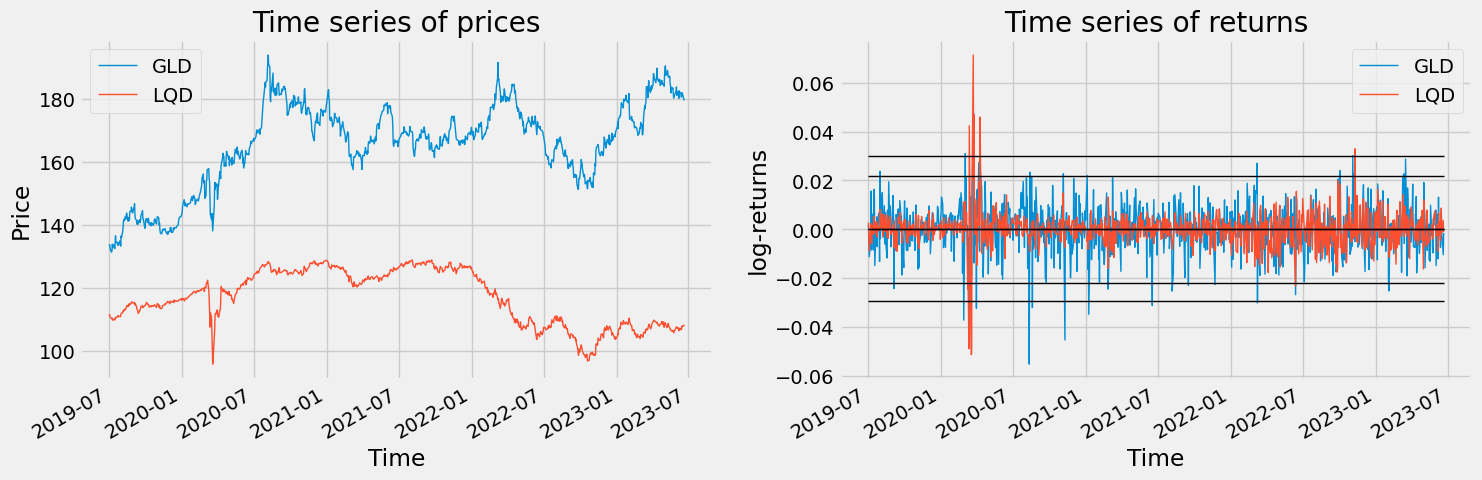

In [246]:
NOSD = 3               # Number Of Standard Deviations
mu = ret.mean()
sig = ret.std()
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

df.plot(ax=ax1)
ax1.set_title("Time series of prices"); ax1.set_xlabel("Time"); ax1.set_ylabel("Price")
ret.plot(ax=ax2)
ax2.set_title("Time series of returns"); ax2.set_xlabel("Time"); ax2.set_ylabel(returns)
ax2.plot(ret.index, len(ret)*[mu], color="k" )
ax2.plot(ret.index, len(ret)*[mu+NOSD*sig], color='k' )
ax2.plot(ret.index, len(ret)*[mu-NOSD*sig], color='k' )
plt.show()

What about the outliers?
We can see that there are returns that are quite bigger than 
 (three standard deviations).
If we assume a Normal distribution for the returns, these outliers can create problems.

Wait a second...
we calculated the standard deviation ret.std() using the data containing the ouliers!!
It means that the value of the standard deviation is aslo affected by the outliers!!

The solution is to use robust estimators of the location and the dispersion of a distribution. They work much better in presence of outliers.

Although there are several alternatives, I prefer to use the median and the MAD. These estimators are more robust than the mean and standard deviation. In the standard deviation, the distances from the mean are squared, so large deviations are weighted more heavily, and thus outliers can heavily influence it. In the MAD instead, the deviations of a small number of outliers are irrelevant.

As explained on wiki, in order to use the MAD as a consistent estimator of the standard deviation, we have to take

where under the assumption of Normal distribution, 
.

In [247]:
median = ret.median()
MAD = ret.mad()
sig_robust = MAD*1.4826
print("STD DEV: \n", sig); print(""); print("Robust STD DEV: \n", sig_robust); 

STD DEV: 
 GLD    0.009930
LQD    0.007303
dtype: float64

Robust STD DEV: 
 GLD    0.010804
LQD    0.006734
dtype: float64


In [248]:
outliers = ret[ret[ np.abs(ret-median)>NOSD*sig_robust ].any(axis=1)]     # outliers
dret = ret.drop(outliers.index)    

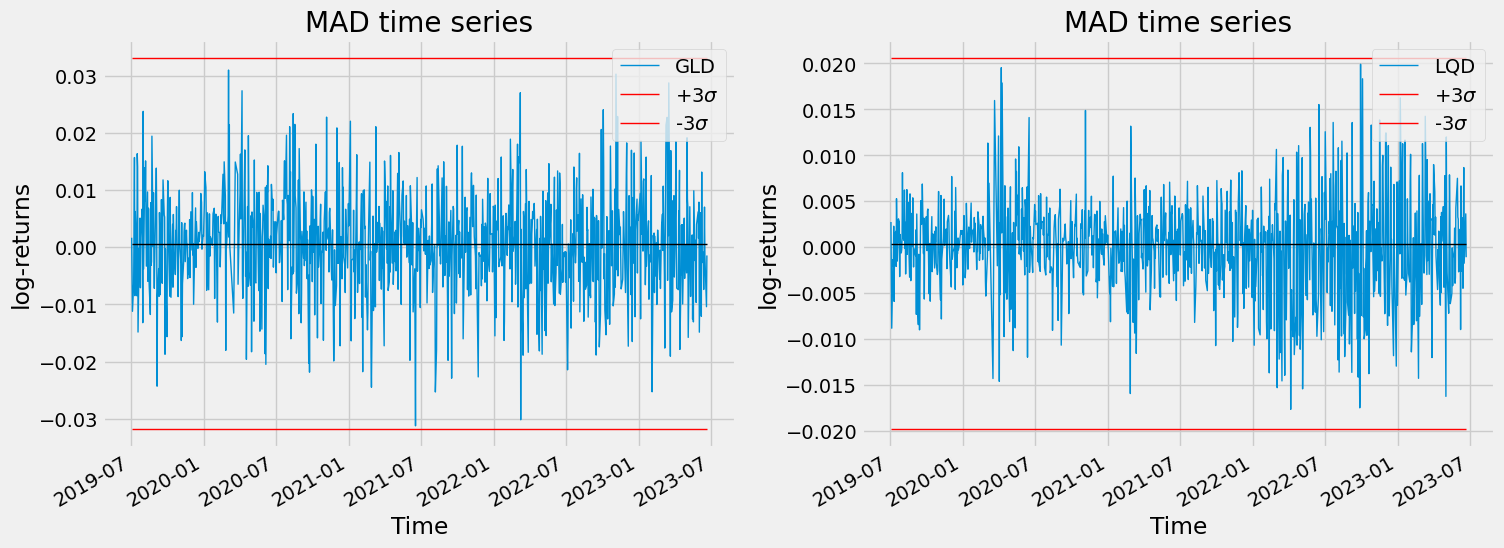

In [249]:
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

for ax, col in zip([ax1,ax2], dret.columns):
    dret[col].plot(ax=ax)
    ax.set_title("MAD time series"); ax.set_xlabel("Time"); ax.set_ylabel(returns)
    ax.plot(dret.index, len(dret)*[median[col]], color="k" )
    ax.plot(dret.index, len(dret)*[median[col]+NOSD*sig_robust[col]], color='r', label="+3$\sigma$" )
    ax.plot(dret.index, len(dret)*[median[col]-NOSD*sig_robust[col]], color='r', label="-3$\sigma$" )
    ax.legend(loc="upper right")
plt.show()

In [250]:

print("We have reduced the initial DIRTY series of returns of size {} to the \
new CLEAN series of size {}.".format(len(ret),len(dret)))

We have reduced the initial DIRTY series of returns of size 999 to the new CLEAN series of size 979.


In [251]:
X = dret[dret.columns[1]]
Y = dret[dret.columns[0]]
print("In our regression Y is {} and X is {}".format(dret.columns[0],dret.columns[1]) )

In our regression Y is GLD and X is LQD


In [252]:
b_ss, a_ss, r_ss, _, std_err_ss = ss.linregress(X,Y)
print("We can use one of the many python functions:\nbeta: {0:6f}, alpha: {1:6f}, R2: {2:6f}, \
standard error: {3:6f}.".format(b_ss, a_ss, r_ss**2, std_err_ss))

beta_tot_OLS = np.cov(X,Y,ddof=1)[0,1] / np.var(X,ddof=1)
alpha_tot_OLS = np.mean(Y) - beta_tot_OLS * np.mean(X)
res = Y - beta_tot_OLS * X - alpha_tot_OLS
std_eps_OLS = np.std(res, ddof=2) 
print("\nOr I can estimate by myself:\nbeta: {}, alpha: {}, sigma: {}".format(beta_tot_OLS, 
                                                                             alpha_tot_OLS, std_eps_OLS))

We can use one of the many python functions:
beta: 0.576103, alpha: 0.000550, R2: 0.120212, standard error: 0.049862.

Or I can estimate by myself:
beta: 0.5761033644569874, alpha: 0.0005498650751642607, sigma: 0.008369595073162308


In [253]:
n = len(X)
x_mean = np.mean(X); y_mean = np.mean(Y)
Sxx = (X-x_mean) @ (X-x_mean)
Syy = (Y-y_mean) @ (Y-y_mean)
Sxy = (X-x_mean) @ (Y-y_mean)
beta_hat = Sxy/Sxx; alpha_hat = y_mean - beta_hat * x_mean    # beta and alpha
print("beta: {} and alpha: {}".format(beta_hat,alpha_hat))
epsilon = Y - beta_hat * X - alpha_hat             # residuals
S2 = epsilon @ epsilon / (n-2); S = np.sqrt(S2)    # unbiased estimator
print("sigma: {}".format(S))
var_beta = S2/Sxx                 # variance of beta 
var_alpha = (X@X) * S2/(Sxx * n)  # variance of alpha 
s_b = np.sqrt(var_beta)           # standard error for beta
s_a = np.sqrt(var_alpha)          # standard error for alpha
R2 = Sxy**2 / (Sxx*Syy)           
print("Standard Error for beta: ", s_b); print("R squared: {}".format(R2))
CI_b = ss.t.interval(0.95, n-2, loc=beta_hat, scale=s_b );  b_up = CI_b[0]; b_down = CI_b[1]
CI_a = ss.t.interval(0.95, n-2, loc=alpha_hat, scale=s_a )
print("Confidence intervals for beta: ", CI_b); print("Confidence intervals for alpha: ", CI_a)

beta: 0.5761033644569872 and alpha: 0.0005498650751642607
sigma: 0.008369595073162308
Standard Error for beta:  0.04986190905815776
R squared: 0.12021167517402331
Confidence intervals for beta:  (0.4782546003304048, 0.6739521285835696)
Confidence intervals for alpha:  (2.4934381788426288e-05, 0.0010747957685400952)


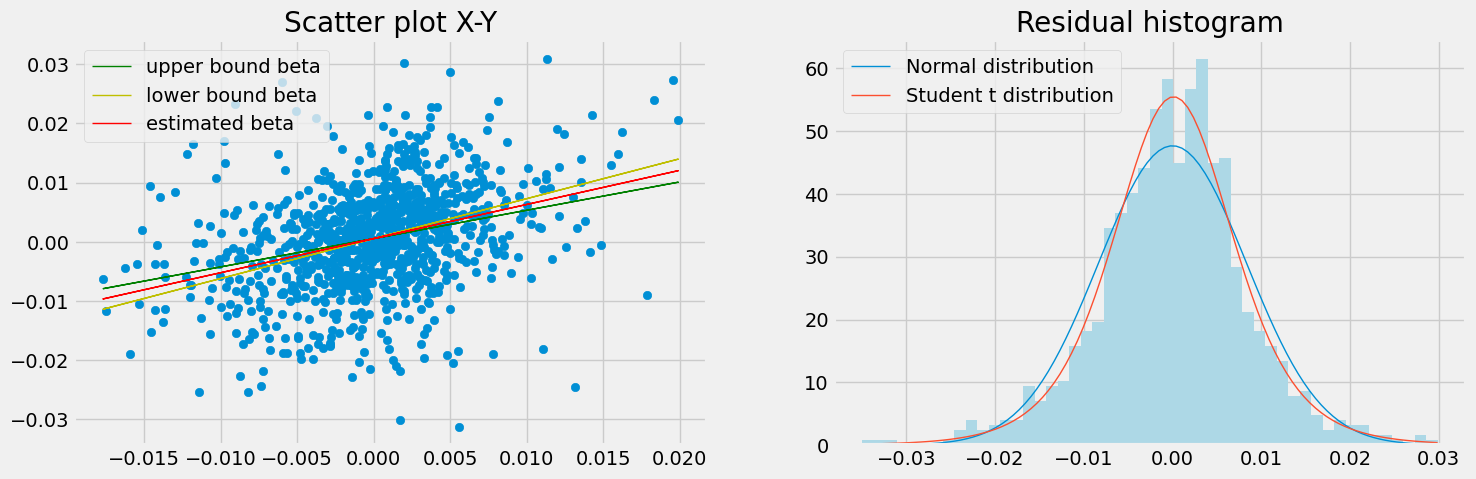

In [254]:
x = np.linspace(res.min(),res.max(),100)    # res are the residuals

fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)
ax1.scatter(X, Y); ax1.set_title("Scatter plot X-Y")
ax1.plot(X, alpha_hat + b_up*X, color="g", label="upper bound beta")
ax1.plot(X, alpha_hat + b_down*X, color="y", label="lower bound beta")
ax1.plot(X, alpha_hat + beta_hat*X, color="red", label="estimated beta"); ax1.legend(loc="upper left")
ax2.plot(x, ss.norm.pdf(x,0,S), label="Normal distribution")
params = ss.t.fit(res)
ax2.plot(x, ss.t.pdf(x, loc=params[1], scale=params[2], df=params[0]), label="Student t distribution")
ax2.hist(res, bins=50, density=True, facecolor="LightBlue")
ax2.legend(); ax2.set_title("Residual histogram"); plt.show()

In [255]:
print("Degrees of freedom of fitted t distribution: ", params[0])

Degrees of freedom of fitted t distribution:  5.993943204152716


In [256]:
Y = dret.columns[0]
X = dret.columns[1]

In [257]:
training_size = 250
ret_train = dret.iloc[:training_size] 
ret_test = dret.iloc[training_size:] 

In [258]:
beta_tr, alpha_tr, _ ,_ ,_  = ss.linregress(ret_train[X], ret_train[Y])
resid_tr = ret_train[Y] - beta_tr * ret_train[X] - alpha_tr
var_eps_ols = resid_tr.var(ddof=2)                       # a possible initial guess for var_eps
print("In the training set the OLS estimators of") 
print("alpha_tr = ", alpha_tr); print("beta_tr = ", beta_tr); print("var_eps = ", var_eps_ols) 

In the training set the OLS estimators of
alpha_tr =  0.0008455882962094373
beta_tr =  0.7294471342097172
var_eps =  6.126771952804719e-05


In [259]:
rolling_window = 50
rolling_beta = []
rolling_std_err = []
rolling_alpha = []

for i in range( len(ret_test) ):
    ret_temp = ret.iloc[ 1+i+training_size-rolling_window : 1+i+training_size ]
    beta_temp, alpha_temp , _ ,_ , std_err_temp  = ss.linregress(ret_temp[X],ret_temp[Y])
    rolling_beta.append(beta_temp)
    rolling_std_err.append(std_err_temp)
    rolling_alpha.append(alpha_temp)
ret_test = ret_test.assign(ols_beta=np.array(rolling_beta))
ret_test = ret_test.assign(ols_std_err=np.array(rolling_std_err))
ret_test = ret_test.assign(ols_alpha=np.array(rolling_alpha))

In [260]:
x = np.array([[alpha_tr],[beta_tr]])        # initial mean of alpha and beta
P = 0.1 * np.eye(2)                         # initial covariance of alpha and beta
eta_alpha = 0.0000001                       # variance of the alpha process 
eta_beta = 0.01                             # variance of the beta process
Q = np.diag([eta_alpha, eta_beta])          # process covariance matrix 
R = np.array([[var_eps_ols]])               # variance for the measurement - 1 dim 
F = np.eye(2)                               # transition matrix
H = np.vstack( (np.ones(len(ret_test)), ret_test[X].values) ).T   

In [261]:
alphas, betas = np.full( len(ret_test), np.NaN ), np.full( len(ret_test), np.NaN )
for i,y in enumerate(ret_test[Y]):
    # predict
    x = F @ x
    P = (F @ P @ F.T) + Q
    
    #update
    S = (H[None,i] @ P @ H[None,i].T) + R     # Here S is a scalar
    K = (P @ H[None,i].T) @ inv(S)             
    r = y - H[None,i]@x                       # residuals
    x = x + K @ r                             # v is a scalar. 
    P = P - K @ H[None,i] @ P                 # K @ H[None,i] is an outer product
    
    alphas[i] = x[0]; betas[i] = x[1]

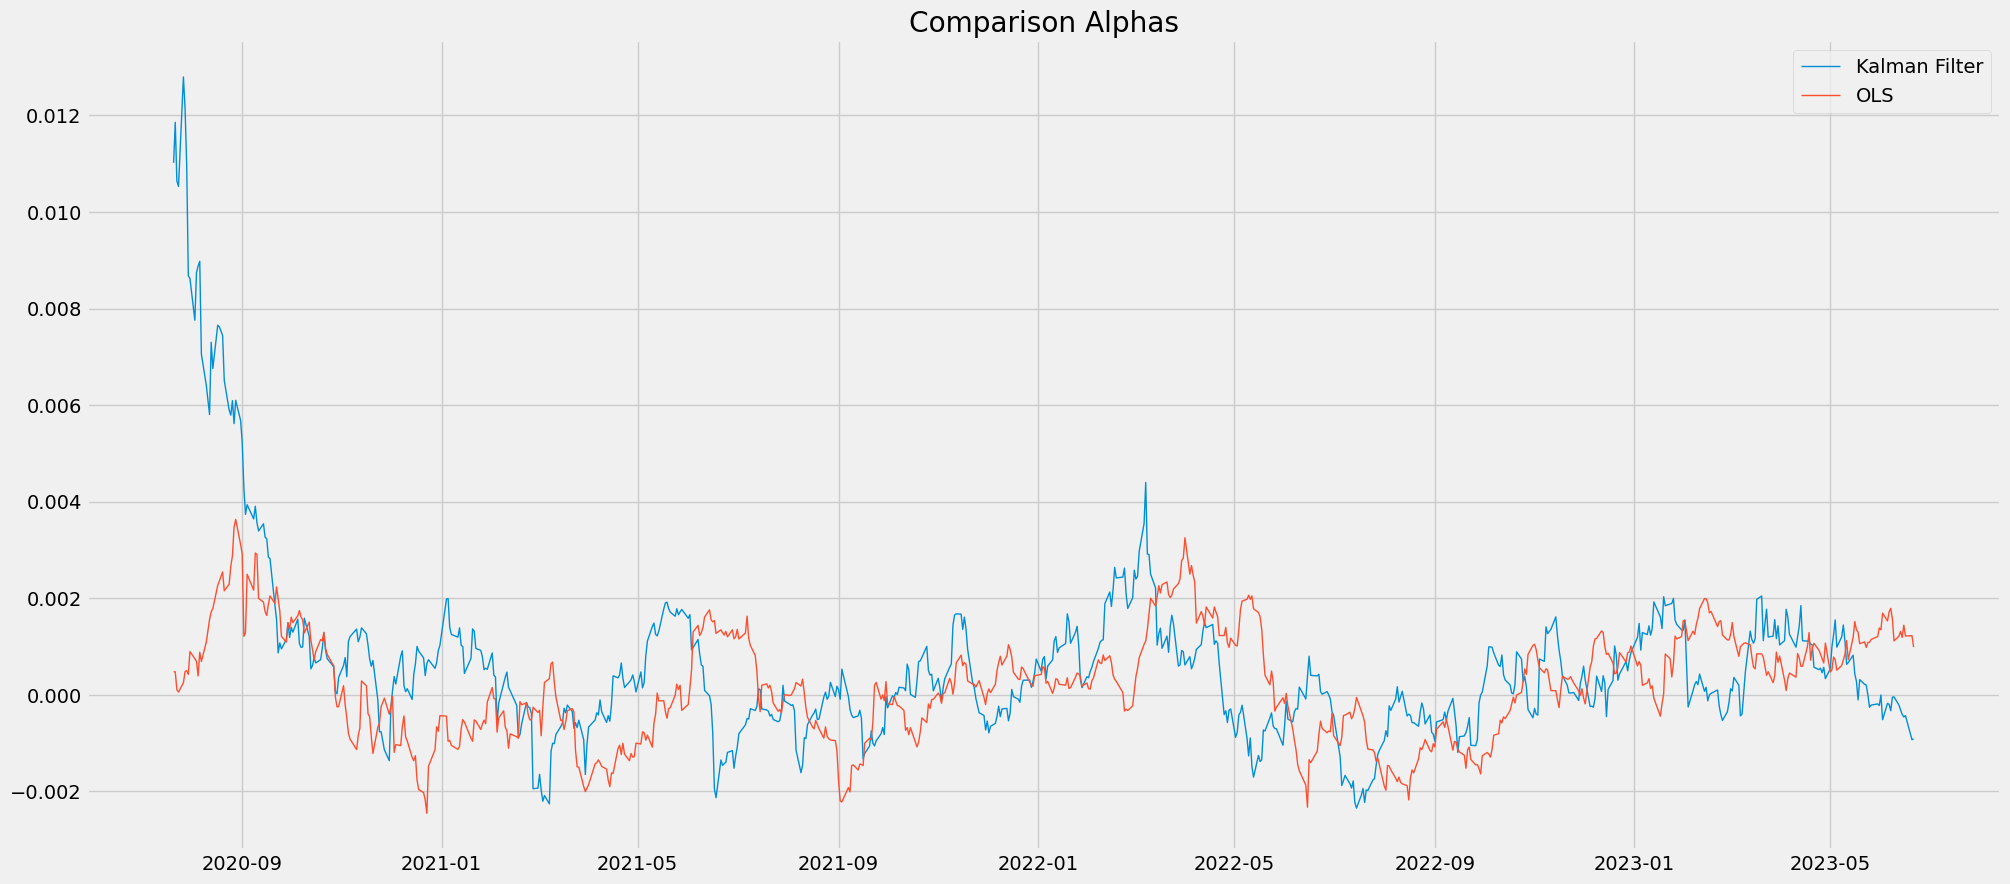

In [262]:
plt.figure(figsize=(22,10))
plt.plot( ret_test.index, alphas, label="Kalman Filter")
plt.plot( ret_test["ols_alpha"], label="OLS" )
plt.legend(); plt.title("Comparison Alphas"); plt.show()

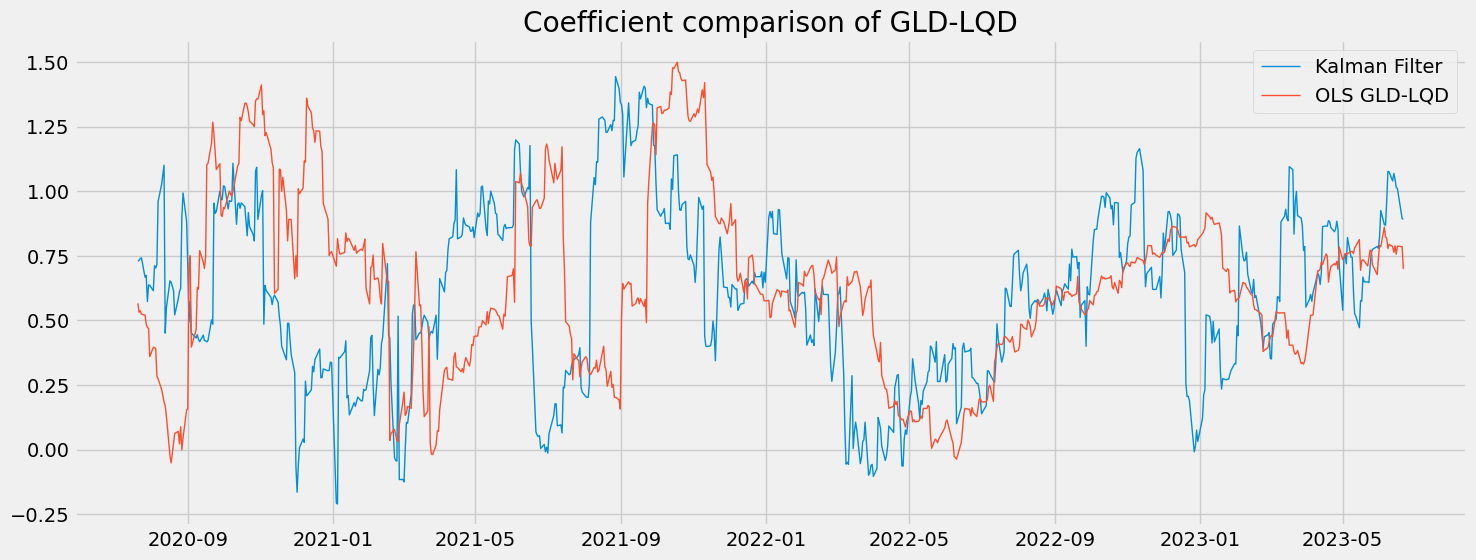

In [263]:
plt.figure(figsize=(16,6))
plt.plot( ret_test.index, betas, label="Kalman Filter")
plt.plot( ret_test["ols_beta"], label="OLS GLD-LQD" )
plt.legend(); plt.title("Coefficient comparison of GLD-LQD"); plt.show()

In [264]:
KR = Kalman_regression(ret_train[X], ret_train[Y])

alpha0, beta0 and var_eps initialized by OLS


In [265]:
dimens = 40
var_eps_x = np.linspace(1e-5,2e-4,dimens)
var_eta_y = np.linspace(1e-5,2e-4,dimens)
X_grid, Y_grid = np.meshgrid(var_eps_x, var_eta_y)
V_grid = np.ones((dimens,dimens))

for i, i_eps in enumerate(var_eps_x):
    for j, j_eta in enumerate(var_eta_y):
        KR.var_eps = i_eps
        KR.var_eta = j_eta
        KR.run()
        V_grid[j,i] = KR.loglikelihood

KR.set_OLS_params()
V = np.ones(dimens)        
for j, j_eta in enumerate(var_eta_y):
    KR.var_eta = j_eta
    KR.run()
    V[j] = KR.loglikelihood

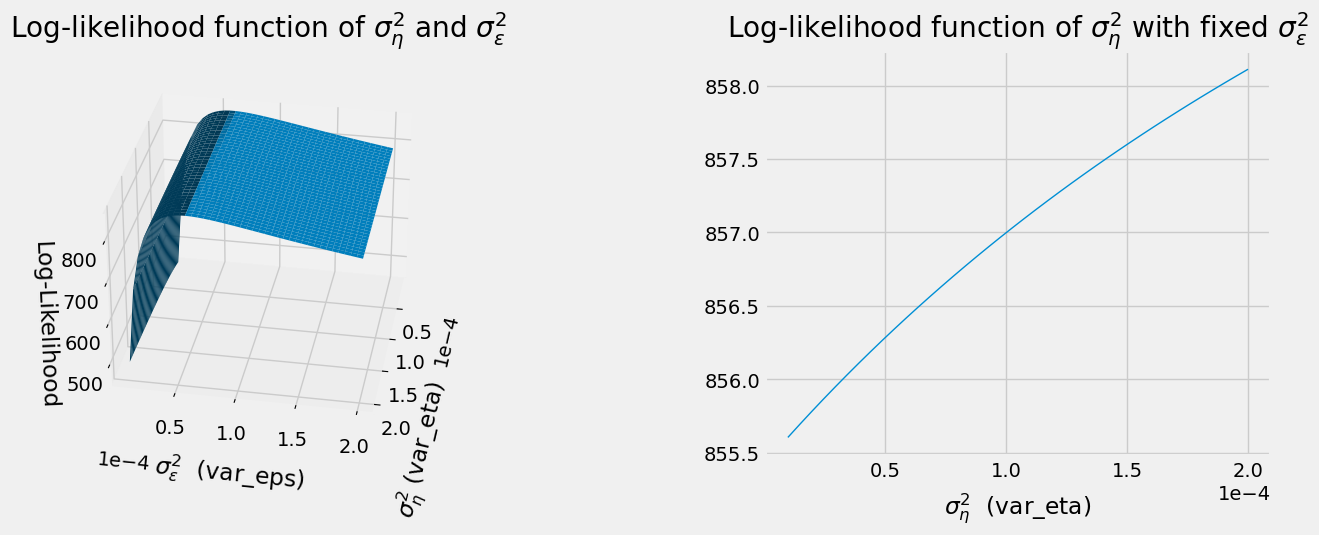

In [266]:
fig = plt.figure(figsize=(16,5))
gs = gridspec.GridSpec(1, 2, width_ratios=[3,2])
ax = fig.add_subplot(gs[0], projection='3d'); ax2 = fig.add_subplot(gs[1])
ax.plot_surface(Y_grid, X_grid, V_grid) #, cmap=cm.ocean
ax.set_title("Log-likelihood function of $\sigma_{\eta}^2$ and $\sigma_{\epsilon}^2$")
ax.set_xlabel("$\sigma_{\eta}^2$ (var_eta)                    ", labelpad=9); 
ax.set_ylabel("$\sigma_{\epsilon}^2$  (var_eps)", labelpad=13); ax.set_zlabel("Log-Likelihood", labelpad=7); 
ax.view_init(30, 10) # this function rotates the 3d plot
ax.ticklabel_format(axis="x", style="sci", scilimits=(-4,2))
ax.ticklabel_format(axis="y", style="sci", scilimits=(-4,2))
ax2.plot(var_eta_y, V)
ax2.set_title("Log-likelihood function of $\sigma_{\eta}^2$ with fixed $\sigma_{\epsilon}^2$")
ax2.set_xlabel("$\sigma_{\eta}^2$  (var_eta)", labelpad=8)
ax2.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.show()

In [267]:
KR.calibrate_MLE()

print("beta_last = ", KR.betas[-1], "P_last = ", KR.Ps[-1])
print("var_eta_MLE = ", KR.var_eta, "var_eps_MLE = ", KR.var_eps, "var_eps_OLS = ", var_eps_ols)

KR.run(ret_test[X], ret_test[Y])

Optimization converged successfully
var_eps = 5.4917858287048756e-05, var_eta = 0.008247206483135452
beta_last =  0.18738854051048826 P_last =  0.18545693687066414
var_eta_MLE =  0.008247206483135452 var_eps_MLE =  5.4917858287048756e-05 var_eps_OLS =  6.126771952804719e-05


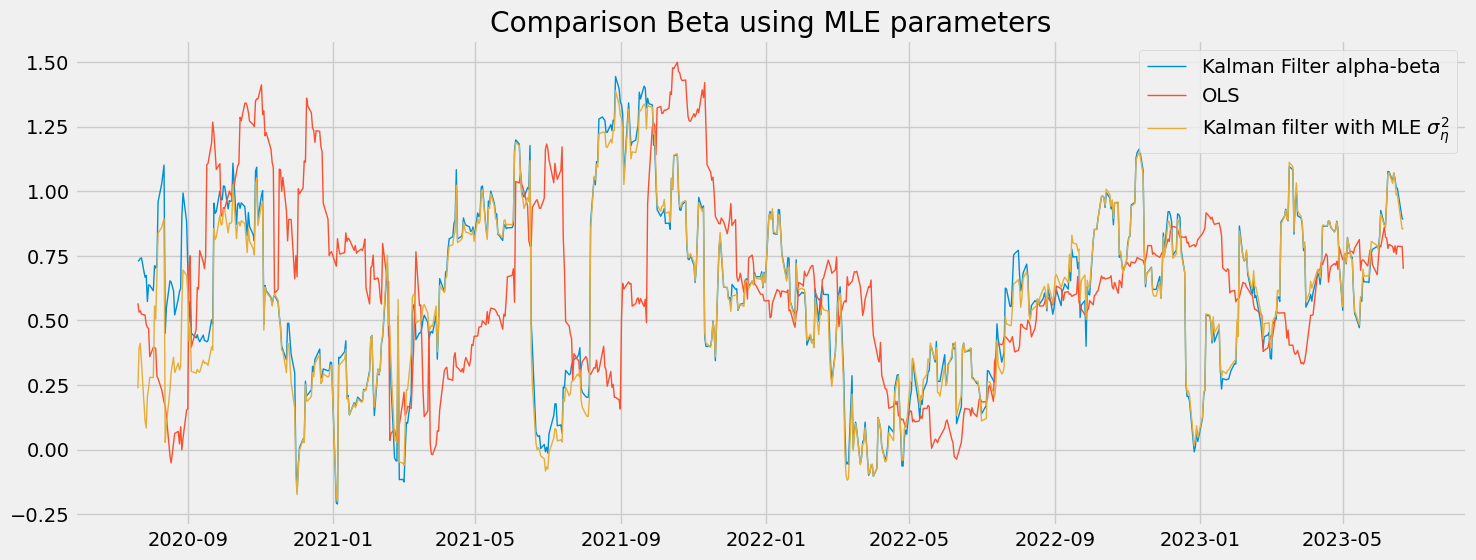

In [268]:

plt.figure(figsize=(16,6))
plt.plot( ret_test.index, betas, label="Kalman Filter alpha-beta")
plt.plot( ret_test["ols_beta"], label="OLS" )
plt.plot(ret_test.index, KR.betas, label="Kalman filter with MLE $\sigma_{\eta}^2$")
plt.legend(); plt.title("Comparison Beta using MLE parameters"); plt.show()